# LGBM을 활용한 베이스라인

In [647]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [648]:
csv_file_path = os.path.join('data', 'train_data.csv')
df = pd.read_csv(csv_file_path) 

#유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
df.sort_values(by=['userID','Timestamp'], inplace=True)

## 2. Feature Engineering

In [649]:
#유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

# testId와 KnowledgeTag의 전체 정답률은 한번에 계산
# 아래 데이터는 제출용 데이터셋에 대해서도 재사용
correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
correct_t.columns = ["test_mean", 'test_sum']
correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']


df = pd.merge(df, correct_t, on=['testId'], how="left")
df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")

In [650]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.952667,1429,0.957333,718
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0.952667,1429,0.917067,3439
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0.952667,1429,0.917067,3439
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0.952667,1429,0.917067,3439
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.952667,1429,0.917067,3439


## 3. Train/Test 데이터 셋 분리

In [651]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함


random.seed(42)
def custom_train_test_split(df, ratio=0.7):
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test


In [652]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [653]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [654]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.560808	valid_1's binary_logloss: 0.688835
[200]	training's binary_logloss: 0.558231	valid_1's binary_logloss: 0.687745
[300]	training's binary_logloss: 0.556043	valid_1's binary_logloss: 0.686936
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.5569	valid_1's binary_logloss: 0.686843
VALID AUC : 0.6808821385721174 ACC : 0.5906040268456376



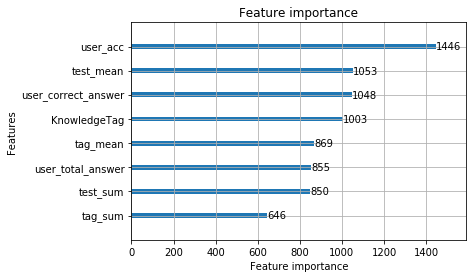

In [656]:
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=500,
                    early_stopping_rounds=100
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

_ = lgb.plot_importance(model)